In [1]:
import pandas as pd
#import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import keras

C:\Users\pekach\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import xgboost as xgb

In [3]:
train_df = pd.read_csv('train.csv', header=0)
test_df = pd.read_csv('test.csv', header=0)

full = train_df.append(test_df, ignore_index = True)

In [4]:
full.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [19]:
full.shape, train_df.shape, test_df.shape

((1309, 12), (891, 12), (418, 11))

In [6]:
embarked = pd.get_dummies( full.Embarked , prefix='Embarked' )
embarked.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [7]:
pclass = pd.get_dummies( full.Pclass , prefix='Pclass' )
pclass.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


In [20]:
#age =[]
#for dataset in full['Age']:  
#    age.append([dataset['Age'] <= 16], 'Age' = 0)
#    age.append((dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age' = 1)
#    age.append((dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age' = 2)
#    age.append((dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age' = 3)
#    age.append( dataset['Age'] > 64, 'Age' = 4)
#

In [8]:
imputed = pd.DataFrame()

# Fill missing values of Age with the average of Age (mean)
imputed[ 'Age' ] = full.Age.fillna( full.Age.mean() )

# Fill missing values of Fare with the average of Fare (mean)
imputed[ 'Fare' ] = full.Fare.fillna( full.Fare.mean() )

imputed.head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


In [9]:
cabin = pd.DataFrame()

# replacing missing cabins with U (for Uknown)
cabin[ 'Cabin' ] = full.Cabin.fillna( 'U' )

# mapping each Cabin value with the cabin letter
cabin[ 'Cabin' ] = cabin[ 'Cabin' ].map( lambda c : c[0] )

# dummy encoding ...
cabin = pd.get_dummies( cabin['Cabin'] , prefix = 'Cabin' )

cabin.head()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1


In [10]:
sex = pd.Series( np.where( full.Sex == 'male' , 1 , 0 ) , name = 'Sex' )

In [11]:
family = pd.DataFrame()

# introducing a new feature : the size of families (including the passenger)
family[ 'FamilySize' ] = full[ 'Parch' ] + full[ 'SibSp' ] + 1

# introducing other features based on the family size
family[ 'Family_Single' ] = family[ 'FamilySize' ].map( lambda s : 1 if s == 1 else 0 )
family[ 'Family_Small' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 2 <= s <= 4 else 0 )
family[ 'Family_Large' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 5 <= s else 0 )

family.head()

,FamilySize,Family_Single,Family_Small,Family_Large
0,2,0,1,0
1,2,0,1,0
2,1,1,0,0
3,2,0,1,0
4,1,1,0,0


In [224]:
# 
full_X = pd.concat( [ imputed , pclass,sex,embarked ,cabin,family] )
full_X.head()

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,...,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,FamilySize,Family_Single,Family_Small,Family_Large
0,22.0,7.2500,0,0,1,1,0,0,1,0,...,0,0,0,0,0,1,2,0,1,0
1,38.0,71.2833,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,2,0,1,0
2,26.0,7.9250,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,1,1,0,0
3,35.0,53.1000,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,2,0,1,0
4,35.0,8.0500,0,0,1,1,0,0,1,0,...,0,0,0,0,0,1,1,1,0,0


In [225]:
full_X.shape

(1309, 22)

In [226]:
train_X = full_X[ 0:891 ]
#train_valid_y = titanic.Survived
test_X = full_X[ 891: ]

In [227]:
y_train = train_df['Survived']

In [228]:
train_X.shape, y_train.shape

((891, 22), (891,))

In [21]:
from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)

feature_columns_to_use = ['Parch']
nonnumeric_columns = ['Sex']

In [22]:
big_X = train_df[feature_columns_to_use].append(test_df[feature_columns_to_use])
big_X_imputed = DataFrameImputer().fit_transform(big_X)

In [24]:
#le = LabelEncoder()
#for feature in nonnumeric_columns:
#    big_X_imputed[feature] = le.fit_transform(big_X_imputed[feature])

In [21]:
#train_X = big_X_imputed[0:train_df.shape[0]].as_matrix()
#test_X = big_X_imputed[train_df.shape[0]::].as_matrix()

## KERAS

In [28]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [20]:
#Normalization
from sklearn import preprocessing
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
train_feature = minmax_scale.fit_transform(train_X)
test_feature = minmax_scale.fit_transform(test_X)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 500)               11500     
_________________________________________________________________
dropout_11 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 200)               100200    
_________________________________________________________________
dropout_12 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 201       
Total params: 111,901
Trainable params: 111,901
Non-trainable params: 0
_________________________________________________________________
None
Train on 712 samples, validate on 179 samples
Epoch 1/20
 - 1s - loss: 0.6865 - acc: 0.5758 - val_loss: 0.6653 - val_acc: 0.6480
Ep

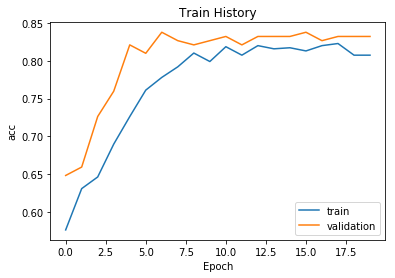

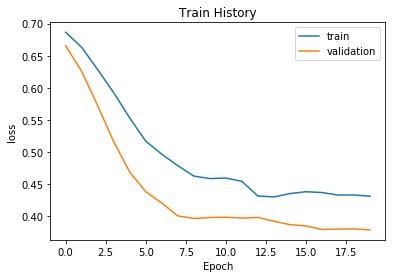

In [45]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()


######################### Model designing
model = Sequential() 
#Input layer
model.add(Dense(units=500, 
                input_dim=22, 
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))
#Hidden layer 1
model.add(Dense(units=200,  
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))
#Output layer
model.add(Dense(units=1,
                kernel_initializer='uniform', 
                activation='sigmoid'))
print(model.summary()) #for showing the structure and parameters
# Defining how to measure performance
model.compile(loss='binary_crossentropy',   
              optimizer='adam', metrics=['accuracy'])
# Train the model
# Verbose=2, showing loss and accuracy change timely
train_history = model.fit(x=train_feature, y=y_train,  
                          validation_split=0.2, epochs=20, 
                          batch_size=200, verbose=2) 
#visualize the loss and accuracy after each epoch
show_train_history(train_history,'acc','val_acc')
show_train_history(train_history,'loss','val_loss')
#For saving weights
#model.save_weights("Savemodels/Cervical_ca(Kaggles)_MLP.h5")
#print('model saved to disk')

### In test data

In [46]:
# Answer sheet
prediction = model.predict_classes(test_feature)

### KERAS OFF

In [22]:
dtc = DecisionTreeClassifier()
dtc.fit(train_X, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [138]:
from sklearn.cross_validation import train_test_split

In [192]:
X_train, X_test, y_train, y_test = train_test_split(train_X, y_train, test_size=0.33, random_state=42)

#### logReg

In [134]:
%%time
#Подбираю параметры для модели LogisticRegression
param_grid = {'penalty': ['l1'], 
              'C': [0.15, 0.5, 1.0, 2.0], 
              'max_iter': [100, 500, 1000]}

logreg = LogisticRegression(random_state=17, n_jobs=-1)
clf = GridSearchCV(logreg, param_grid=param_grid, scoring='roc_auc', n_jobs=-1)
clf.fit(X_train, y_train)
print(clf.best_score_, '\n', clf.best_params_)

0.841037632458 
 {'C': 1.0, 'max_iter': 100, 'penalty': 'l1'}
Wall time: 21.1 s


C:\Users\pekach\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


In [196]:
logreg = LogisticRegression(random_state=17, n_jobs=-1, penalty='l2', C=10000, max_iter=100)
logreg.fit(X_train, y_train)

C:\Users\pekach\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [214]:
%%time
#Подбираю параметры для модели LogisticRegression
param_grid = {'penalty': ['l2'], 
              'C': [0.15, 0.5, 1.0, 2.0], 
              'max_iter': [100, 500, 1000]}

logreg_3 = LogisticRegression(random_state=17, n_jobs=-1)
clf = GridSearchCV(logreg, param_grid=param_grid, scoring='roc_auc', n_jobs=-1)
clf.fit(X_train, y_train)
print(clf.best_score_, '\n', clf.best_params_)

0.846713983956 
 {'C': 0.5, 'max_iter': 100, 'penalty': 'l2'}
Wall time: 4.08 s


C:\Users\pekach\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


In [197]:
logreg_3 = LogisticRegression(random_state=17, n_jobs=-1, penalty='l2', C=0.5, max_iter=100)
logreg_3.fit(X_train, y_train)

C:\Users\pekach\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [217]:
%%time
#Подбираю параметры для модели LogisticRegression
param_grid = {'penalty': ['l1', 'l2'], 
              'C': [0.01, 0.2, 0.9,0.7,1.5], 
              'max_iter': [500, 1000, 2000]}

logreg_2 = LogisticRegression(random_state=17, n_jobs=-1)
clf = GridSearchCV(logreg_2, param_grid=param_grid, scoring='roc_auc', n_jobs=-1)
clf.fit(X_train, y_train)
print(clf.best_score_, '\n', clf.best_params_)

0.846534367448 
 {'C': 0.7, 'max_iter': 500, 'penalty': 'l2'}
Wall time: 4.4 s


C:\Users\pekach\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


In [198]:
logreg_2 = LogisticRegression(random_state=17, n_jobs=-1, penalty='l1', C=1.5, max_iter=500)
logreg_2.fit(X_train, y_train)

C:\Users\pekach\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


LogisticRegression(C=1.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

##### случайный лес

In [144]:
%%time
#Подбираю параметры для модели RandomForestClassifier
param_grid = {'n_estimators': [100, 500, 1000], 
              'criterion': ['gini', 'entropy'], 
              'min_samples_leaf': [1, 2, 5]}

forest = RandomForestClassifier(random_state=17, n_jobs=-1)
clf = GridSearchCV(forest, param_grid=param_grid, scoring='roc_auc', n_jobs=-1)
clf.fit(X_train, y_train)
print(clf.best_score_, '\n', clf.best_params_)

0.848770401924 
 {'criterion': 'entropy', 'min_samples_leaf': 2, 'n_estimators': 500}
Wall time: 21.7 s


In [199]:
forest = RandomForestClassifier(n_estimators=2000, random_state=17, n_jobs=-1, criterion='entropy', min_samples_leaf=5)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [31]:
%%time
#Подбираю параметры для модели RandomForestClassifier
param_grid = {'n_estimators': [50, 200, 700], 
              'criterion': ['gini', 'entropy'], 
              'min_samples_leaf': [2, 4, 10]}

forest_2 = RandomForestClassifier(random_state=17, n_jobs=-1)
clf = GridSearchCV(forest_2, param_grid=param_grid, scoring='roc_auc', n_jobs=-1)
clf.fit(X_train, y_train)
print(clf.best_score_, '\n', clf.best_params_)

0.830141981124 
 {'criterion': 'gini', 'min_samples_leaf': 4, 'n_estimators': 200}
Wall time: 16.2 s


In [200]:
forest_2 = RandomForestClassifier(n_estimators=200, random_state=17, n_jobs=-1, criterion='gini', min_samples_leaf=4)
forest_2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

#### XGBOOST

In [147]:
param_grid = {'learning_rate': [0.01,0.05,0.1], 
              'n_estimators': [100,200,300,500], 
              'max_depth': [1,2,5]}

xgb_cl = xgb.XGBClassifier(random_state=17,n_jobs=-1)
clf = GridSearchCV(xgb_cl, param_grid=param_grid, scoring='roc_auc', n_jobs=-1)
clf.fit(X_train, y_train)
print(clf.best_score_, '\n', clf.best_params_)

0.84793850459 
 {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}


In [201]:
gbm = xgb.XGBClassifier(max_depth=1, n_estimators=500, learning_rate=0.05).fit(X_train, y_train)
#predictions = gbm.predict(test_X)

In [66]:
knn = KNeighborsClassifier( n_jobs=-1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

### Validation

In [202]:
cv_iterator = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [203]:
#Простая комбинация 3 моделей с подобранными параметрами
vcl = VotingClassifier(estimators=[('gbm',gbm),('logreg_3',logreg_3),('logreg_2',logreg_2)\
                                   ,('rf', forest), ('lr', logreg)], voting='soft')
vcl = vcl.fit(X_train, y_train)
#vcl_preds_proba_up = vcl.predict_proba(X_valid)
#vcl_preds_proba_up_test = vcl.predict_proba(X_test_plus)
#score = roc_auc_score(y_valid, vcl_preds_proba_up[:, 1])
#print('VotingClassifier (soft, predict_proba): ', round(score, 3))

C:\Users\pekach\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Users\pekach\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
C:\Users\pekach\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


In [204]:
#predict = dtc.predict(test_X)
predict_cv = vcl.predict(X_test)


In [205]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score

#print('precision', precision_score(y_test, predict_cv))
#print('recall', recall_score(y_test, predict_cv))
#print('accuracy', accuracy_score(y_test, predict_cv))
#print('f1', f1_score(y_test, predict_cv))


In [206]:
roc_auc_score(y_test, predict_cv)


0.79988095238095247

In [209]:
from sklearn.model_selection import learning_curve, validation_curve

def plot_learning_curve(estimator, title, X, y,label_y, ylim=None, cv=None, scoring='roc_auc', 
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(label_y)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Wall time: 22 s


<module 'matplotlib.pyplot' from 'C:\\Users\\pekach\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

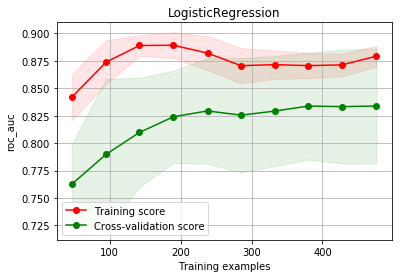

In [210]:
%%time
plot_learning_curve(vcl, 'LogisticRegression',
                    X_train, y_train, scoring='roc_auc', cv=cv_iterator, n_jobs=-1, label_y='roc_auc')

#### К отправке

In [207]:
predict = vcl.predict(test_X)

In [208]:
submission = pd.DataFrame({ 'PassengerId': test_df['PassengerId'],
                            'Survived': prediction[:,0]})
submission.to_csv("submission.csv", index=False)